***1. Setup and Data Loading***

Imports: We begin by importing the necessary libraries:
os for handling directory paths.

numpy for numerical operations.

matplotlib.pyplot for plotting graphs.

tensorflow and its submodules for building and training the neural network.

seaborn for advanced visualisation of the confusion matrix.


Mount Google Drive: We use Google Colab’s drive.mount function to access the data stored in Google Drive.


Data Paths: Define the paths for the training and testing data directories.

***Data Augmentation and Image Pre-processing***

ImageDataGenerator: This function generates batches of tensor image data with real-time data augmentation.

rescale: Normalises the pixel values to the range [0, 1].

rotation_range: Randomly rotates the images by up to 20 degrees.

width_shift_range and height_shift_range: Randomly translates the images horizontally and vertically.

shear_range: Applies shear transformations.

zoom_range: Randomly zooms into the images.

horizontal_flip: Randomly flips the images horizontally.

fill_mode: Determines how to fill newly created pixels, set to ‘nearest’ in this case.

train_generator: Creates batches of augmented training data.

validation_generator: Creates batches of normalised validation data (without augmentation).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Data paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/data/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/data/Testing'

# Data Augmentation and Image Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


***2. Model Building***

***Loading Pre-trained VGG16 and Adding Custom Layers***

Loading VGG16:

base_model: Load the pre-trained VGG16 model without its top (final) fully connected layers (include_top=False). This allows us to add custom layers suitable for our classification task. The input shape is set to (128, 128, 3) to match the size of our images.

Adding Custom Layers:

Flatten: Flatten the output from the VGG16 base model to convert the 2D matrix into a 1D vector.

Dense Layer: Add a fully connected layer with 1024 units and ReLU activation to introduce non-linearity.

Dropout: Add dropout with a rate of 0.5 to prevent overfitting by randomly setting 50% of the input units to 0 at each update during training.

Predictions: Add the final output layer with 4 units (one for each class) and softmax activation to output a probability distribution over the classes.

Freeze Base Model Layers: Set all layers in the base model to non-trainable to keep the pre-trained weights unchanged during training.

Compile Model:

Optimizer: Use the Adam optimiser with a learning rate of 0.0001 for adaptive learning.

Loss Function: Use categorical cross-entropy as the loss function since this is a multi-class classification problem.

Metrics: Track accuracy during training and validation.

Model Summary: Print a summary of the model architecture.

In [23]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adding custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

    class_weights = {
    0: 1.0,
    1: 1.2,
    2: 0.8,
    3: 1.1  # Adjust these weights based on class distribution
}

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

***3. Model Training***

Training the Model: Use the fit method to train the model.

train_generator: The training data generator.

steps_per_epoch: Number of steps per epoch (total training samples divided by batch size).

validation_data: The validation data generator.

validation_steps: Number of steps per validation epoch (total validation samples divided by batch size).

epochs: Number of complete passes through the training dataset.

In [24]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:2611: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  ndimage.interpolation.affine_transform(


Epoch 1/5
178/178 [==============================] - 74s 345ms/step - loss: 1.0063 - accuracy: 0.6452 - val_loss: 0.6130 - val_accuracy: 0.7586
Epoch 2/5
178/178 [==============================] - 61s 340ms/step - loss: 0.6528 - accuracy: 0.7331 - val_loss: 0.5344 - val_accuracy: 0.7937
Epoch 3/5
178/178 [==============================] - 67s 376ms/step - loss: 0.5986 - accuracy: 0.7630 - val_loss: 0.5463 - val_accuracy: 0.7852
Epoch 4/5
178/178 [==============================] - 60s 339ms/step - loss: 0.5785 - accuracy: 0.7713 - val_loss: 0.4904 - val_accuracy: 0.8352
Epoch 5/5
178/178 [==============================] - 60s 337ms/step - loss: 0.5629 - accuracy: 0.7775 - val_loss: 0.5156 - val_accuracy: 0.8047


***Define the Reinforcement Learning Environment***

***Implement Reinforcement Learning Algorithm***

In [25]:
pip install stable-baselines3[extra] gymnasium

In [26]:
import gymnasium
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

In [27]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TumourClassificationEnv(gym.Env):
    def __init__(self, model, data_generator):
        super(TumourClassificationEnv, self).__init__()
        self.model = model
        self.data_generator = data_generator
        self.action_space = spaces.Discrete(4)  # 4 classes: glioma, meningioma, pituitary, notumor
        self.observation_space = spaces.Box(low=0, high=1, shape=(128, 128, 3), dtype=np.float32)
        self.current_step = 0
        self.data = self.data_generator.next()
        self.current_image, self.current_label = self.data[0][self.current_step], self.data[1][self.current_step]

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_step = 0
        self.data = self.data_generator.next()
        self.current_image, self.current_label = self.data[0][self.current_step], self.data[1][self.current_step]
        return self.current_image

    def step(self, action):
        reward = 1 if action == np.argmax(self.current_label) else -1
        self.current_step += 1
        done = self.current_step >= len(self.data[0])
        if not done:
            self.current_image, self.current_label = self.data[0][self.current_step], self.data[1][self.current_step]
        return self.current_image, reward, done, {}

    def render(self):
        pass

***4. Evaluation and Visualisation***

Model Evaluation: Evaluate the model on the validation data.

eval_result: Contains the loss and accuracy on the validation set.

print statements: Output the validation loss and accuracy.

Plotting Accuracy and Loss:

Extract training and validation accuracy and loss from the history object.

epochs_range: Range of epochs (0 to 9, since there are 10 epochs).

plt.figure: Create a new figure for plotting.

Subplots: Create two subplots, one for accuracy and one for loss.

Plotting: Plot training and validation accuracy/loss for each epoch.

Legend: Add a legend to each plot.

Title: Add titles to the plots to distinguish between accuracy and loss.

Predictions:
Y_pred: Predict class probabilities for the validation set.

y_pred: Convert predicted probabilities to class labels (using np.argmax).

Confusion Matrix:

cm: Compute the confusion matrix to evaluate the accuracy of the classifications.

Heatmap: Plot the confusion matrix using seaborn’s heatmap function.

Annotations: Add annotations to each cell for clarity.

Labels: Label the axes with actual and predicted class names.

Classification Report: Generate a detailed report of the precision, recall, F1-score, and support for each class.

target_names: List of class names for display in the report.

print statements: Output the classification report to the console.


41/41 [==============================] - 14s 353ms/step - loss: 0.5165 - accuracy: 0.8040
Validation Loss: 0.5164545178413391
Validation Accuracy: 0.8039664626121521


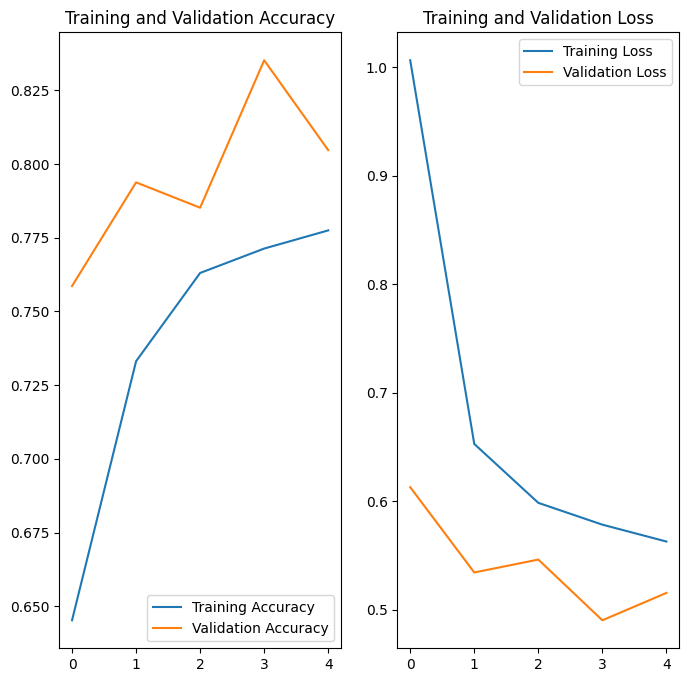

41/41 [==============================] - 10s 237ms/step
Confusion Matrix


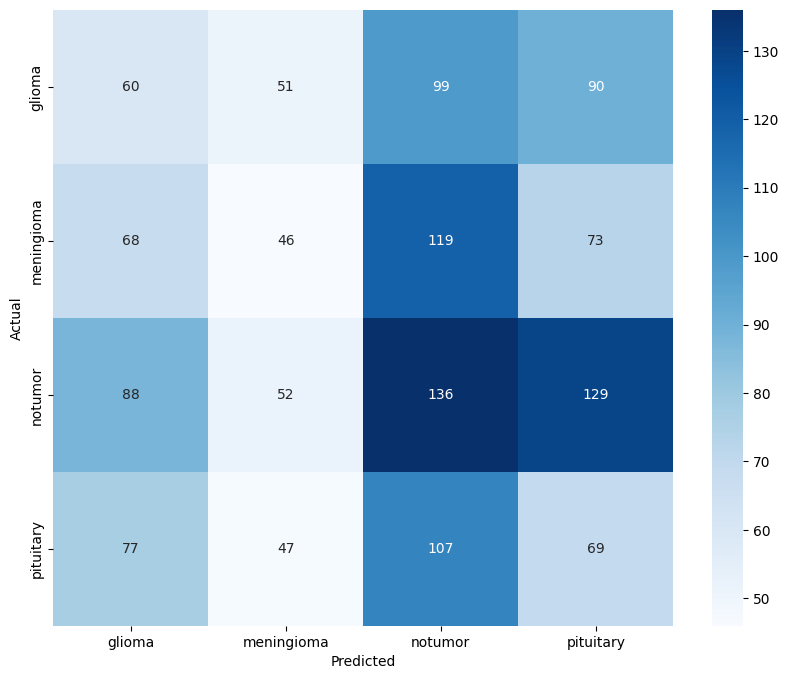

Classification Report
              precision    recall  f1-score   support

      glioma       0.20      0.20      0.20       300
  meningioma       0.23      0.15      0.18       306
     notumor       0.30      0.34      0.31       405
   pituitary       0.19      0.23      0.21       300

    accuracy                           0.24      1311
   macro avg       0.23      0.23      0.23      1311
weighted avg       0.24      0.24      0.23      1311



In [28]:
# Evaluate the model
eval_result = model.evaluate(validation_generator)
print(f"Validation Loss: {eval_result[0]}")
print(f"Validation Accuracy: {eval_result[1]}")

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Confusion Matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

***5. Inference Script***

predict_image Function:

image.load_img: Load an image from the specified path and resize it to (128, 128) pixels.

image.img_to_array: Convert the image to a numpy array.

np.expand_dims: Add an extra dimension to the array to create a batch of one image.

Normalisation: Scale pixel values to the range [0, 1].

model.predict: Predict class probabilities for the image.

np.argmax: Convert predicted probabilities to class labels.

class_labels: Map numerical labels back to class names.

Example Usage:

image_path: Path to a sample image.

predicted_class: Predict the class of the sample image and print the result.

1/1 [==============================] - 0s 133ms/step


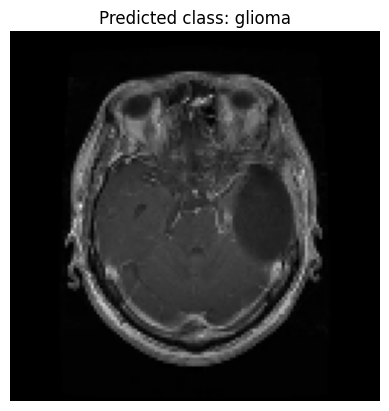

The predicted class is: glioma


In [29]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(image_path, model, class_indices, target_size=(128, 128), visualize=False):
    """
    Predicts the class of an image using the given model.

    Parameters:
    - image_path: str, path to the image file.
    - model: keras.Model, the trained model for prediction.
    - class_indices: dict, a dictionary mapping class names to their indices.
    - target_size: tuple, the target size for the image (default is (128, 128)).
    - visualize: bool, whether to display the image (default is False).

    Returns:
    - str, the predicted class name.
    """
    try:
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)
        class_labels = list(class_indices.keys())
        predicted_class_name = class_labels[predicted_class[0]]

        # Optionally visualize the image
        if visualize:
            plt.imshow(img)
            plt.title(f"Predicted class: {predicted_class_name}")
            plt.axis('off')
            plt.show()

        return predicted_class_name

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/data/Testing/glioma/Te-gl_0015.jpg'
class_indices = train_generator.class_indices  # Assuming train_generator is defined
predicted_class = predict_image(image_path, model, class_indices, visualize=True)
print(f"The predicted class is: {predicted_class}")